### House Keeping ###

In [1]:
# import packages
from pandas_datareader import data, wb
import pandas as pd
import numpy as np
import datetime
import nltk

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

%matplotlib inline

In [2]:
from warnings import filterwarnings
filterwarnings('ignore')

### Pull Data ###

In [196]:
# set start and end time 
start = datetime.datetime(2014, 1, 21)
end = datetime.datetime(2019, 11, 29)

In [197]:
# pull TSLA stock price data from yahoo 
TSLA = data.DataReader("TSLA", 'yahoo', start, end)

In [198]:
# pull fama-french 5 factors data from Fama/French Data Library
factor = data.DataReader('F-F_Research_Data_5_Factors_2x3_daily', 'famafrench',
                         (start+datetime.timedelta(days = 1)),end)
factors = factor[0]

In [199]:
# calculate TSLA daily excess return = return - risk-free rate
ER = pd.DataFrame(TSLA['Adj Close'].pct_change()[1:]-factors['RF'])

In [200]:
# confirm dates in factors and TSLA returns are the same
sum(ER.index == factors.index) == factors.shape[0]

TypeError: 'numpy.float64' object is not callable

### Factor Model and Abnormal Return ###

In [202]:
# use linear regression in the factor model 
import statsmodels.api as sm

ols = sm.OLS(ER,factors.drop('RF',axis=1)).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      0   R-squared (uncentered):                   0.192
Model:                            OLS   Adj. R-squared (uncentered):              0.189
Method:                 Least Squares   F-statistic:                              69.85
Date:                Fri, 17 Jan 2020   Prob (F-statistic):                    1.14e-65
Time:                        15:18:17   Log-Likelihood:                          3297.2
No. Observations:                1476   AIC:                                     -6584.
Df Residuals:                    1471   BIC:                                     -6558.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.0110      0.001     12.833      0.000       0.009       0.013
SMB            0.0027      0.001      1.938      0.053   -3.24e-05       0.005
HML           -0.0047      0.002     -2.872      0.004      -0.008      -0.001
RMW           -0.0073      0.002     -3.411      0.001      -0.011      -0.003
CMA           -0.0084      0.003     -3.003      0.003      -0.014      -0.003
==============================================================================
Omnibus:                      217.467   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2439.107
Skew:                           0.267   Prob(JB):                         0.00
Kurtosis:                       9.275   Cond. No.                         3.92
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [203]:
# calculate abnormal return = TSLA excess return - TSLA returns predicted by factor model
AR = pd.DataFrame(ER.reset_index()[0] - ols.predict())
AR.index = ER.index

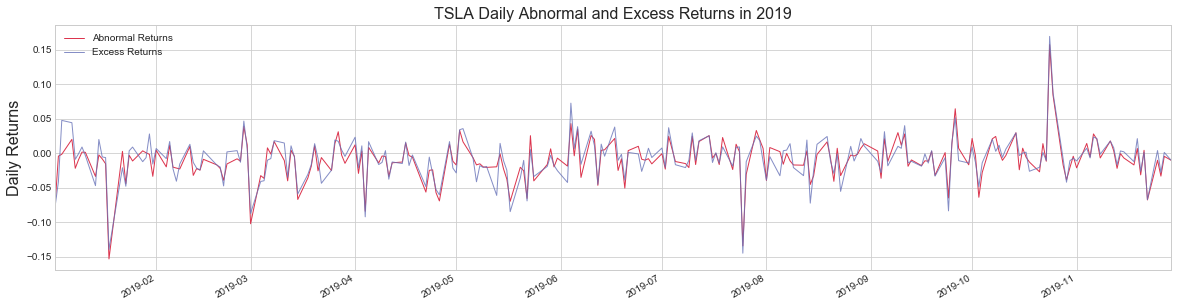

In [206]:
# plot time-series Abnromal Returns
ax = AR[AR.index>datetime.datetime(2019, 1, 1)].plot(color='#dc354e',alpha=1,figsize=(20,5),lw=1,legend=True)
_ = ER[ER.index>datetime.datetime(2019, 1, 1)].plot(color='#6772b8',alpha=0.8,figsize=(20,5),lw=1, ax = ax)
ax.set_ylabel("Daily Returns",fontsize=16)
ax.set_xlabel("")
ax.set_title('TSLA Daily Abnormal and Excess Returns in 2019',fontsize=16)
ax.legend(["Abnormal Returns", "Excess Returns"])

Text(0.5,1,'TSLA Daily Adjusted Close Price')

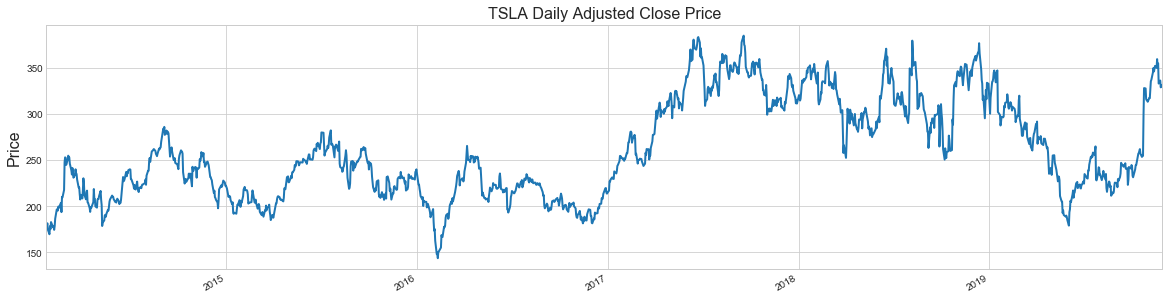

In [207]:
# plot time-series Price Movements
ax = TSLA['Adj Close'].plot(figsize=(20,5),lw=2, title='TSLA Adjusted Close Price',legend=False)
ax.set_ylabel("Price",fontsize=16)
ax.set_xlabel("")
ax.set_title('TSLA Daily Adjusted Close Price',fontsize=16)

In [208]:
# construct project target variable as binary indicator
# binary return = 0 if abnormal retunrs is negative 
binary_ret = AR
binary_ret[binary_ret<=0] = 0
binary_ret[binary_ret>0] = 1

In [209]:
binary_ret.shape

(1476, 1)

### Web-scraping WSJ & NYT headlines from Factiva ###

In [210]:
# factiva headlines extraction function credit to 
# Extracting meta data from Factiva to CSV via Python' by Phil Reed
# reference: https://philreeddata.wordpress.com/2016/05/20/extracting-meta-data-from-factiva-to-csv-via-python/

from lxml.html import parse
def get_dataframe(html,n):
    parsed = parse(html)
    doc = parsed.getroot()
    cells = doc.findall('.//td')
    len(cells)
    fout = open('factiva-parsed{}.txt'.format(n), 'w')
    fout.write("TITLE\tSOURCE\tTIME\tDATE\tWORD COUNT\n")
    fout.flush()
    NA = "N/A"
    T = "\t"
    NL = "\n"
    for (i, cell) in enumerate(cells):
      if (i<2):
        #ignore first two results, they are from the page header
        continue
      # col1: title, from <b>
      titles = cell.findall('.//b')
      if titles:
        # Two unicode chars (left/right quo) cause problems --> replace
        fout.write(titles[0].text_content().strip().replace(u"\u2018", "'").replace(u"\u2019", "'") + u"\t")
      else:
        fout.write(NA+T)
      # col2-5: from div class=leadFields, comma-separated
      fields = cell.find_class('leadFields')
      if fields:
        raw_fields = fields[0].text_content()
        field_split = raw_fields.split(',')
        # col2: source
        fout.write(field_split[0] + T)
        # col3: time - optional
        has_time = ":" in field_split[1]
        date_col = 2
        words_col = 3
        if has_time:
          fout.write(field_split[1].strip() + T)
        else:
          # skip the time field
          fout.write(NA+T)
          date_col = 1
          words_col = 2
        # col4: date
        fout.write(field_split[date_col].strip() + T)
        # col5: number of words
        fwordss = [int(s) for s in field_split[words_col].split() if s.isdigit()] #get the integers
        if fwordss:
          fout.write(str(fwordss[0]) + NL)
        else:
          fout.write(NA+NL)
      else:
        fout.write(NA+T+NA+T+NA+T+NA+NL)
      fout.flush()
    fout.close()
    data = pd.read_csv('factiva-parsed{}.txt'.format(n), sep="	", header=0, nrows = 100)
    return data

In [211]:
# read html into dataframe
headlines = pd.DataFrame()
for i in range(1,42):
    html = 'Factiva{}.html'.format(i)
    headlines = pd.concat([headlines,get_dataframe(html,i)])

headlines = headlines.dropna(how='all').reset_index(drop=True)

In [212]:
headlines2 = headlines[['TITLE','DATE']]

# to lower case
headlines2['TITLE'] = headlines['TITLE'].str.lower().copy()
# remove duplicated news headlines 
headlines2.drop_duplicates('TITLE',inplace = True)

In [213]:
# Reuter specific headline cleaning 

# delete word 'buzz' from headlines 
headlines2['TITLE'] = headlines2['TITLE'].str.replace('buzz', '')
headlines2['TITLE'] = headlines2['TITLE'].str.replace('brief', '')
headlines2['TITLE'] = headlines2['TITLE'].str.replace('update', '')

# delete any row with word 'press digest' since those headliens doesn't contain any info
headlines2 = headlines2[~headlines2['TITLE'].str.contains("press digest")]

headlines2 = headlines2.reset_index(drop=True)

### Clean Text Data ###

In [214]:
import string 
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer


#remove punctuation
clean_news = headlines2['TITLE'].str.replace('[{}]'.format(string.punctuation), ' ')

# remove word 'tesla'
clean_news = clean_news.str.replace('tesla', '')

# remove stopwords
stop_words = stopwords.words('english')
clean_news = clean_news.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words) and len(word)>3]))

# remove numbers in text
clean_news = clean_news.apply(lambda x: ' '.join([i for i in x.split() if not i.isdigit()]))

# stem words
porter = PorterStemmer()
clean_news = clean_news.apply(lambda x: ' '.join([porter.stem(word) for word in x.split()]))

In [215]:
# associate news with date
clean_news = pd.concat([clean_news,pd.to_datetime(headlines2['DATE'])],axis=1)

# keep only news post 2015
clean_news = clean_news[clean_news['DATE'] >= pd.Timestamp(2014, 1, 21)]

Text(0.5,1,'Count of News Publications by Date')

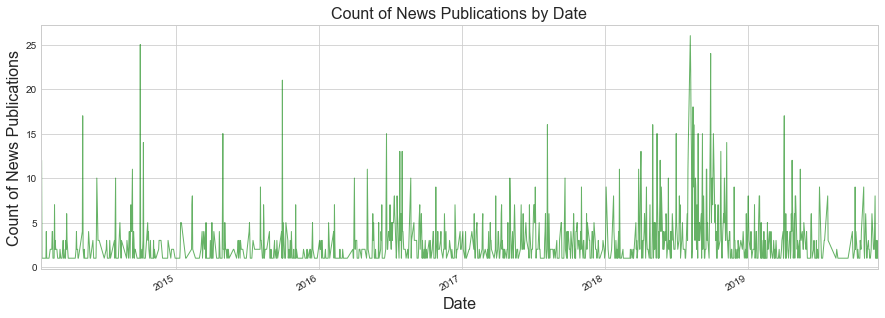

In [216]:
# plot time-series count of news publications by date 
temp = clean_news.groupby('DATE').count()
ax = temp.plot(color='green',alpha=0.6,figsize=(15,5),lw=1,legend=False)
ax.set_ylabel("Count of News Publications",fontsize = 16)
ax.set_xlabel("Date",fontsize=16)
ax.set_title('Count of News Publications by Date',fontsize=16)

In [217]:
# concate news that occur in the same day 
news_date = pd.DataFrame(columns = ['TITLE','DATE'])

unique_dates = clean_news['DATE'].unique()

for date in unique_dates:
    day_headlines = ''.join(clean_news['TITLE'][clean_news['DATE']== date])
    news_date = news_date.append(pd.DataFrame.from_dict({'TITLE':[day_headlines],'DATE':[date]}))
    
news_date = news_date.reset_index(drop=True)

In [218]:
# drop news not published on trading day/ no stock data

news_date = news_date[news_date['DATE'].apply(lambda x: x in binary_ret.index)].reset_index(drop=True)

In [219]:
news_date.shape

(994, 2)

### Topic Modeling ###

In [220]:
from nltk import word_tokenize,sent_tokenize # tokenizing
from nltk.stem import PorterStemmer,LancasterStemmer  # using the Porter Stemmer and Lancaster Stemmer and others
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer  # lammatizer from WordNet

# for named entity recognition (NER)
from nltk import ne_chunk

# vectorizers for creating the document-term-matrix (DTM)
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

df = news_date.copy()

#### extract features and create DTM with TF-IDF values 

In [221]:
vect =TfidfVectorizer(stop_words=stop_words,max_features=1000)

vect_text=vect.fit_transform(df['TITLE'])

In [222]:
idf=vect.idf_
dd=dict(zip(vect.get_feature_names(), idf))
l=sorted(dd, key=(dd).get)

#### Latent Dirichlet Allocation (LDA)

gridsearch to find the optimal LDA params

In [27]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
# Define Search Param
search_params = {'n_components': [5, 6, 7, 8], 'learning_decay': [0.3,.5, .7, .9]}

lda = LatentDirichletAllocation()

model = GridSearchCV(lda, param_grid=search_params)
model.fit(vect_text)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                   

extract optimal params

In [28]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(vect_text))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 5}
Best Log Likelihood Score:  -10697.882980392023
Model Perplexity:  3052.756195212272


fit model params with LDA

In [29]:
lda_model=LatentDirichletAllocation(n_components=5,learning_decay = 0.9,
                                    learning_method='online',random_state=0,max_iter=10) 

lda_top=lda_model.fit_transform(vect_text)

In [30]:
print(lda_top.shape)  # (no_of_doc,no_of_topics)
print(lda_top[0])

(994, 5)
[0.77105534 0.05654693 0.05932428 0.05631014 0.05676332]


In [31]:
sum=0
for i in lda_top[0]:
  sum=sum+i
print(sum)

0.9999999999999999


In [38]:
#composition of doc {j} for eg
j = 5
print("Document {}: ".format(j))
for i,topic in enumerate(lda_top[j]):
  print("Topic ",i,": ",topic*100,"%")

Document 5: 
Topic  0 :  17.55026168246594 %
Topic  1 :  68.63259789584643 %
Topic  2 :  4.655946652068816 %
Topic  3 :  4.570982340761753 %
Topic  4 :  4.590211428857082 %


#### Topic Modeling Visualization 

key words for each topic

In [223]:
vocab = vect.get_feature_names()
print("Topics found via LDA:")

for i, comp in enumerate(lda_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic #"+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

Topics found via LDA:
Topic #0: 
musk electr model stock move say drive elon motor compani 

Topic #1: 
batteri electr china plant maker factori model invest auto charg 

Topic #2: 
model musk elon electr batteri vehicl say execut order photo 

Topic #3: 
polici trump strategi green averag wheeli cort southwest cheap motorexpo 

Topic #4: 
crash autopilot fatal driver pickup investig korea probe famili warn 



Visualize words in a topic by word cloud

In [224]:
from wordcloud import WordCloud

# Generate a word cloud image for given topic
def draw_word_cloud(index):
  imp_words_topic=""
  comp=lda_model.components_[index]
  vocab_comp = zip(vocab, comp)
  sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:500]
  for word in sorted_words:
    imp_words_topic=imp_words_topic+" "+word[0]

  wordcloud = WordCloud(width=300, height=200,background_color="white", max_words=5000, contour_width=3, contour_color='steelblue').generate(imp_words_topic)
  plt.figure(figsize=(5,5))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout()
  plt.show()

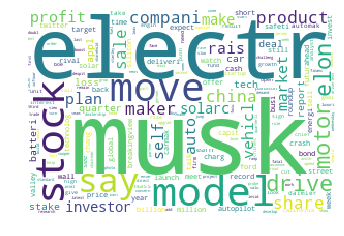

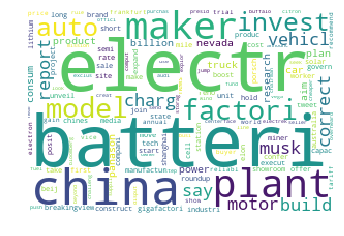

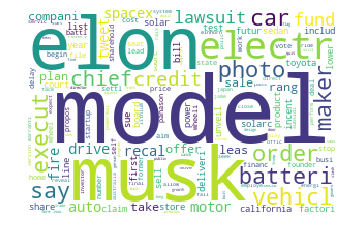

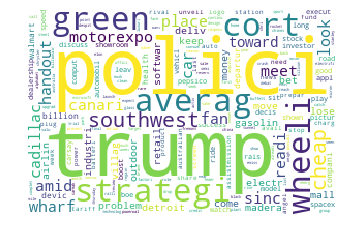

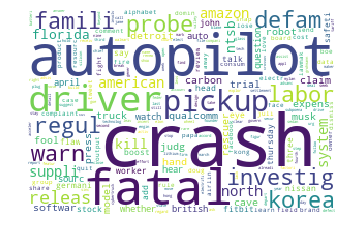

In [225]:
# draw wordcloud
for i in range(lda_model.n_components):
    draw_word_cloud(i)

topics distribution across documents

Text(0.5,1,'Dominant Topics Distribution across Documents')

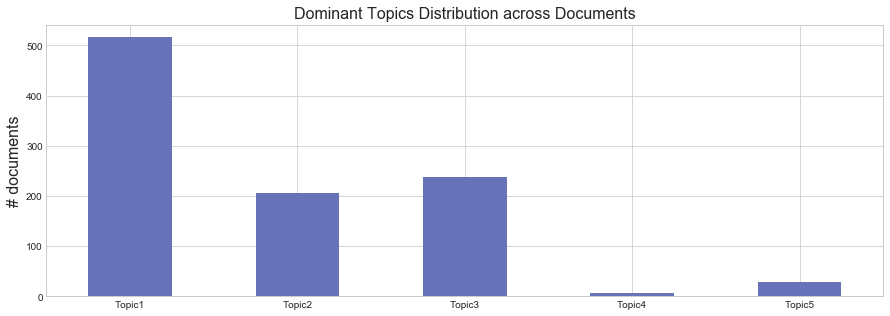

In [261]:
# column names
topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(lda_top.shape[0])]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_top, 2), columns=topicnames, index=docnames)
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index()
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution['Topic Num'] = 'Topic ' + df_topic_distribution['Topic Num'].map(str) 

df_topic_distribution = df_topic_distribution.set_index('Topic Num').sort_index()


ax = df_topic_distribution['Num Documents'].plot(kind='bar',rot=0,figsize = (15,5),color='#6772b8')
ax.set_xlabel('')
ax.set_ylabel('# documents',fontsize=16)
ax.set_xticklabels(['Topic1','Topic2','Topic3','Topic4','Topic5'])
ax.set_title('Dominant Topics Distribution across Documents',fontsize=16)

Get dominant topic for each document

In [62]:
# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.77,0.06,0.06,0.06,0.06,0
Doc1,0.05,0.04,0.82,0.04,0.04,2
Doc2,0.58,0.04,0.04,0.04,0.3,0
Doc3,0.29,0.61,0.03,0.03,0.03,1
Doc4,0.05,0.8,0.05,0.05,0.05,1
Doc5,0.18,0.69,0.05,0.05,0.05,1
Doc6,0.7,0.08,0.08,0.08,0.08,0
Doc7,0.8,0.05,0.05,0.05,0.05,0
Doc8,0.85,0.04,0.04,0.04,0.04,0
Doc9,0.86,0.03,0.03,0.03,0.03,0


pyLDAvis visualization

In [57]:
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, vect_text, vect, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0       92.553070 -149.772324       1        1  45.949563
2       -9.390883  -72.346268       2        1  22.956527
1       52.853752  -40.512180       3        1  19.677414
4      106.515945  -81.267509       4        1   6.521426
3       28.460941 -128.333786       5        1   4.895069, topic_info=    Category       Freq       Term      Total  loglift  logprob
212  Default   8.000000      crash   8.000000  30.0000  30.0000
68   Default  10.000000  autopilot  10.000000  29.0000  29.0000
332  Default   5.000000      fatal   5.000000  28.0000  28.0000
273  Default   4.000000     driver   4.000000  27.0000  27.0000
651  Default   7.000000      plant   7.000000  26.0000  26.0000
..       ...        ...        ...        ...      ...      ...
519   Topic5   0.420620       look   5.663765   0.4168  -5.9695
546   Topic5   0.437046       meet   7.402580   0.1874  -5.9312
131   Topic5   0.413540        car  14.909178  -0.5680  -5.9865
444   Topic5   0.354208   industri   4.748164   0.4213  -6.1413
831   Topic5   0.347610    softwar   4.297921   0.5021  -6.1601

[292 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
19        1  0.171400     aim
19        2  0.342800     aim
19        3  0.514200     aim
23        3  0.628808   allen
31        1  0.418871  amazon
...     ...       ...     ...
971       2  0.134355   watch
971       4  0.134355   watch
978       1  0.821502    week
984       2  0.658774  wheeli
984       5  0.329387  wheeli

[418 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 5, 4])

In [64]:
#pyLDAvis.save_html(panel, 'lda.html')

merge topic data with stock

In [63]:
output = pd.DataFrame(lda_top, columns=topicnames)
output['DATE'] = news_date.DATE
output = output.set_index('DATE')

In [64]:
topic_stock = pd.merge(binary_ret,output,left_index=True, right_index=True,how='left')
topic_stock = topic_stock.fillna(0)

In [65]:
topic_stock.shape

(1476, 6)

Visualize dominant topic vs. stock change

In [189]:
temp = pd.merge(binary_ret,output,left_index=True, right_index=True)
dominant_topic_stock = pd.concat([df_document_topic['dominant_topic'].reset_index(drop=True),temp[0].reset_index(drop=True)],axis=1)

In [190]:
dominant_topic_stock = pd.concat([df_document_topic['dominant_topic'].reset_index(drop=True),temp[0].reset_index(drop=True)],axis=1)
dominant_topic_stock.rename(columns = {0: 'stock change'}, inplace = True)

topic_freq = dominant_topic_stock.groupby('dominant_topic').count()['stock change']
count_series = dominant_topic_stock.groupby(['dominant_topic', 'stock change']).size()

count_series = count_series.to_frame(name = 'size').reset_index()
topic_freq = topic_freq.to_frame(name = 'total size').reset_index()

temp = count_series.set_index('dominant_topic').join(topic_freq.set_index('dominant_topic'),how='left')
temp['percentage of topic total'] = temp['size']/temp['total size']
temp = temp.reset_index()

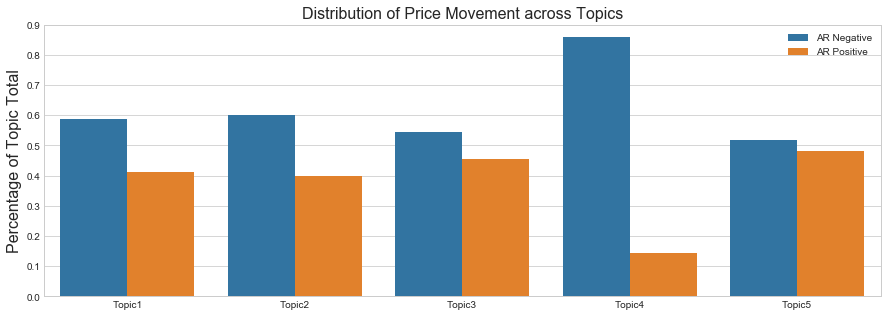

In [192]:
plt.figure(figsize = (15,5))
g = sns.barplot(x = 'dominant_topic',y='percentage of topic total',
                hue="stock change",data = temp)
g.set_title('Distribution of Price Movement across Topics',fontsize=16)
g.set_xlabel('',fontsize=16)
g.set_ylabel('Percentage of Topic Total',fontsize=16)
g.set_xticklabels(['Topic1','Topic2','Topic3','Topic4','Topic5'])
#plt.legend(labels = ['Price Decreased','Price Increased'])
legend = g.legend()
legend.texts[0].set_text("AR Negative")
legend.texts[1].set_text("AR Positive")

### Modeling ###

In [69]:
price_change = pd.get_dummies(topic_stock[0],drop_first=True)
train_test_data = pd.concat([price_change,topic_stock.drop([0],axis=1)],axis=1)
train_test_data.rename(columns = {1: 'Price Change'},inplace = True)
train_test_data.head()

,Price Change,Topic0,Topic1,Topic2,Topic3,Topic4
Date,,,,,,
2014-01-22,1,0.000000,0.000000,0.000000,0.00000,0.000000
2014-01-23,1,0.187018,0.687528,0.043187,0.04128,0.040988
2014-01-24,0,0.727808,0.068894,0.067991,0.06765,0.067657
2014-01-27,0,0.000000,0.000000,0.000000,0.00000,0.000000
2014-01-28,1,0.000000,0.000000,0.000000,0.00000,0.000000


In [70]:
y = train_test_data['Price Change']
X = train_test_data.drop(['Price Change'],axis = 1)

train-test split

In [71]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 0,stratify = y)

0. DummyClassifier (baseline) 

In [81]:
from sklearn.dummy import DummyClassifier
from sklearn import metrics

dc = DummyClassifier().fit(X_train, y_train)
dc_y_pred = dc.predict(X_test)

dc_cv = metrics.f1_score(y_test,dc_y_pred)
dc_cv

0.4380952380952381

1. Logistic Regression

In [82]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr_grid_values = {'C': np.arange(1, 20, 2),
                  'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                  'random_state': [0],
                 'class_weight':['balanced']}
lr_grid = GridSearchCV(lr, param_grid = lr_grid_values, scoring = 'f1')
lr_grid.fit(X_train, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                         'class_weight': ['balanced'], 'random_state': [0],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_tr

In [83]:
# Model Parameters
print("Best Model's Params: ", lr_grid.best_params_)

# fetch Best Model
best_lr_model = lr_grid.best_estimator_

# 10-fold CV to get avg accuracy score
from sklearn.model_selection import cross_val_score
k = 10
lr_cv = cross_val_score(best_lr_model, X_train, y_train, cv = k, scoring = 'f1')
lr_cv.mean()

Best Model's Params:  {'C': 11, 'class_weight': 'balanced', 'random_state': 0, 'solver': 'newton-cg'}


0.46203832287720364

2. Naive Bayes

In [84]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB().fit(X_train,y_train)
nb_cv = cross_val_score(GaussianNB(), X_train, y_train, cv = k, scoring = 'f1')
nb_cv.mean()

0.1802748015873016

3. Ridge Classifier

In [85]:
from sklearn.linear_model import RidgeClassifier

rc = RidgeClassifier()
rc_grid_values = {'alpha': np.arange(30,50,1),
                  'solver':['auto','lsqr','sparse_cg','cholesky'],
                  'random_state': [0],
                 'class_weight':['balanced']}
rc_grid = GridSearchCV(rc, param_grid = rc_grid_values, scoring = 'f1')
rc_grid.fit(X_train, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RidgeClassifier(alpha=1.0, class_weight=None,
                                       copy_X=True, fit_intercept=True,
                                       max_iter=None, normalize=False,
                                       random_state=None, solver='auto',
                                       tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
       47, 48, 49]),
                         'class_weight': ['balanced'], 'random_state': [0],
                         'solver': ['auto', 'lsqr', 'sparse_cg', 'cholesky']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [91]:
# Model Parameters
print("Best Model's Params: ", rc_grid.best_params_)

# fetch Best Model
best_rc_model = rc_grid.best_estimator_

# 5-fold CV to get avg accuracy score
rc_cv = cross_val_score(best_rc_model, X_train, y_train, cv = k, scoring = 'f1')
rc_cv.mean()

Best Model's Params:  {'alpha': 42, 'class_weight': 'balanced', 'random_state': 0, 'solver': 'sparse_cg'}


0.4582890789304116

4. Linear Support Vector Machine

In [87]:
from sklearn.svm import LinearSVC

lsvc = LinearSVC()
lsvc_grid_values = {'dual':[True,False],
                    'C':np.arange(5,20,5),
                    'random_state':[0],
                   'class_weight':['balanced']}
lsvc_grid = GridSearchCV(lsvc, param_grid = lsvc_grid_values, scoring = 'f1')
lsvc_grid.fit(X_train, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='warn', n_jobs=None,
             param_grid={'C': array([ 5, 10, 15]), 'class_weight': ['balanced'],
                         'dual': [True, False], 'random_state': [0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [259]:
?LinearSVC()

In [88]:
# Model Parameters
print("Best Model's Params: ", lsvc_grid.best_params_)

# fetch Best Model
best_lsvc_model = lsvc_grid.best_estimator_

# 5-fold CV to get avg accuracy score
lsvc_cv = cross_val_score(best_lsvc_model, X_train, y_train, cv = k, scoring = 'f1')
lsvc_cv.mean()

Best Model's Params:  {'C': 5, 'class_weight': 'balanced', 'dual': True, 'random_state': 0}


0.46163231894019574

5. Kernalized SVM

In [89]:
from sklearn.svm import SVC

svc = SVC()
svc_grid_values = {'C':np.arange(1,20,2),
                   'kernel':['linear','poly','rbf','sigmoid'],
                   'random_state':[0],
                  'class_weight':['balanced']}
svc_grid = GridSearchCV(svc, param_grid = svc_grid_values, scoring = 'f1')
svc_grid.fit(X_train, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                         'class_weight': ['balanced'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'random_state': [0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [90]:
# Model Parameters
print("Best Model's Params: ", svc_grid.best_params_)

# fetch Best Model
best_svc_model = svc_grid.best_estimator_

# 5-fold CV to get avg accuracy score
svc_cv = cross_val_score(best_svc_model, X_train, y_train, cv = k, scoring = 'f1')
svc_cv.mean()

Best Model's Params:  {'C': 13, 'class_weight': 'balanced', 'kernel': 'poly', 'random_state': 0}


0.4830188679245283

6. KNN 

In [92]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn_grid_values = {'n_neighbors':np.arange(1,20,2),
                   'weights':['uniform','distance'],
                   'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
                   'leaf_size':np.arange(20,41,5)}
knn_grid = GridSearchCV(knn, param_grid = knn_grid_values, scoring = 'f1')
knn_grid.fit(X_train, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': array([20, 25, 30, 35, 40]),
                         'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [93]:
# Model Parameters
print("Best Model's Params: ", knn_grid.best_params_)

# fetch Best Model
best_knn_model = knn_grid.best_estimator_

# 5-fold CV to get avg accuracy score
knn_cv = cross_val_score(best_knn_model, X_train, y_train, cv = k, scoring = 'f1')
knn_cv.mean()

Best Model's Params:  {'algorithm': 'auto', 'leaf_size': 20, 'n_neighbors': 1, 'weights': 'uniform'}


0.47804311130948046

7. Random Forest

In [94]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf_grid_values = {'min_samples_split':np.arange(2,5,1),
                  'min_samples_leaf':np.arange(1,5,1),
                  'min_weight_fraction_leaf':np.arange(0,0.5,0.1),
                  'bootstrap':[True, False],
                  'class_weight':["balanced"],
                  'random_state':[0]
                  }
rf_grid = GridSearchCV(rf, param_grid = rf_grid_values, scoring = 'f1')
rf_grid.fit(X_train, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_sco...
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid=

In [95]:
# Model Parameters
print("Best Model's Params: ", rf_grid.best_params_)

# fetch Best Model
best_rf_model = rf_grid.best_estimator_

# 5-fold CV to get avg accuracy score
rf_cv = cross_val_score(best_rf_model, X_train, y_train, cv = k, scoring = 'f1')
rf_cv.mean()

Best Model's Params:  {'bootstrap': True, 'class_weight': 'balanced', 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.4, 'random_state': 0}


0.40852544803872376

8. Gradient-Boosted Decision Trees

In [96]:
from sklearn.ensemble import GradientBoostingClassifier

In [97]:
gbc = GradientBoostingClassifier()
gbc_grid_values = {'loss':['deviance', 'exponential'],
                   'learning_rate':np.arange(0.1,1,0.1),
                   'min_samples_leaf':np.arange(1,3,1),
                   'min_weight_fraction_leaf':np.arange(0,0.5,0.1),
                   'random_state':[0]
                  }
gbc_grid = GridSearchCV(gbc, param_grid = gbc_grid_values, scoring = 'f1')
gbc_grid.fit(X_train, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_it...
                                                  validation_fractio

In [98]:
# Model Parameters
print("Best Model's Params: ", gbc_grid.best_params_)

# fetch Best Model
best_gbc_model = gbc_grid.best_estimator_

# 5-fold CV to get avg accuracy score
gbc_cv = cross_val_score(best_gbc_model, X_train, y_train, cv = k, scoring = 'f1')
gbc_cv.mean()

Best Model's Params:  {'learning_rate': 0.7000000000000001, 'loss': 'deviance', 'min_samples_leaf': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 0}


0.3112007458638659

### Evaluation ###

In [103]:
train_output = pd.DataFrame([dc_cv,lr_cv.mean(),nb_cv.mean(),rc_cv.mean(),
              lsvc_cv.mean(),svc_cv.mean(),knn_cv.mean(),
              rf_cv.mean(),gbc_cv.mean(),0.5664],columns = ['F1'])
train_output['Score Type'] = 'Train Accuracy'
train_output.index = ['Dummy Classifier (Baseline)','Logistic','Naive Bayes','Ridge','LinearSVM','Kernalized SVM',
                          'KNN','Random Forest','Gradient Boosting','Neural Networks']
test_output = pd.DataFrame([dc_cv,
                            metrics.accuracy_score(y_test,best_lr_model.predict(X_test)),
                            metrics.accuracy_score(y_test,nb.predict(X_test)),
                            metrics.accuracy_score(y_test,best_rc_model.predict(X_test)),
                            metrics.accuracy_score(y_test,best_lsvc_model.predict(X_test)),
                            metrics.accuracy_score(y_test,best_svc_model.predict(X_test)),
                            metrics.accuracy_score(y_test,best_knn_model.predict(X_test)),
                            metrics.accuracy_score(y_test,best_rf_model.predict(X_test)),
                            metrics.accuracy_score(y_test,best_gbc_model.predict(X_test)),
                            0.5060],columns = ['F1'])
test_output['Score Type'] = 'Test Accuracy'
test_output.index = ['Dummy Classifier (Baseline)','Logistic','Naive Bayes','Ridge','LinearSVM','Kernalized SVM',
                          'KNN','Random Forest','Gradient Boosting','Neural Networks']

In [104]:
accuracy_scores = pd.concat([train_output,test_output]).reset_index()

In [105]:
accuracy_scores

,index,F1,Score Type
0,Dummy Classifier (Baseline),0.438095,Train Accuracy
1,Logistic,0.462038,Train Accuracy
2,Naive Bayes,0.180275,Train Accuracy
3,Ridge,0.458289,Train Accuracy
4,LinearSVM,0.461632,Train Accuracy
5,Kernalized SVM,0.483019,Train Accuracy
6,KNN,0.478043,Train Accuracy
7,Random Forest,0.408525,Train Accuracy
8,Gradient Boosting,0.311201,Train Accuracy
9,Neural Networks,0.566400,Train Accuracy


Visualize accuracy score

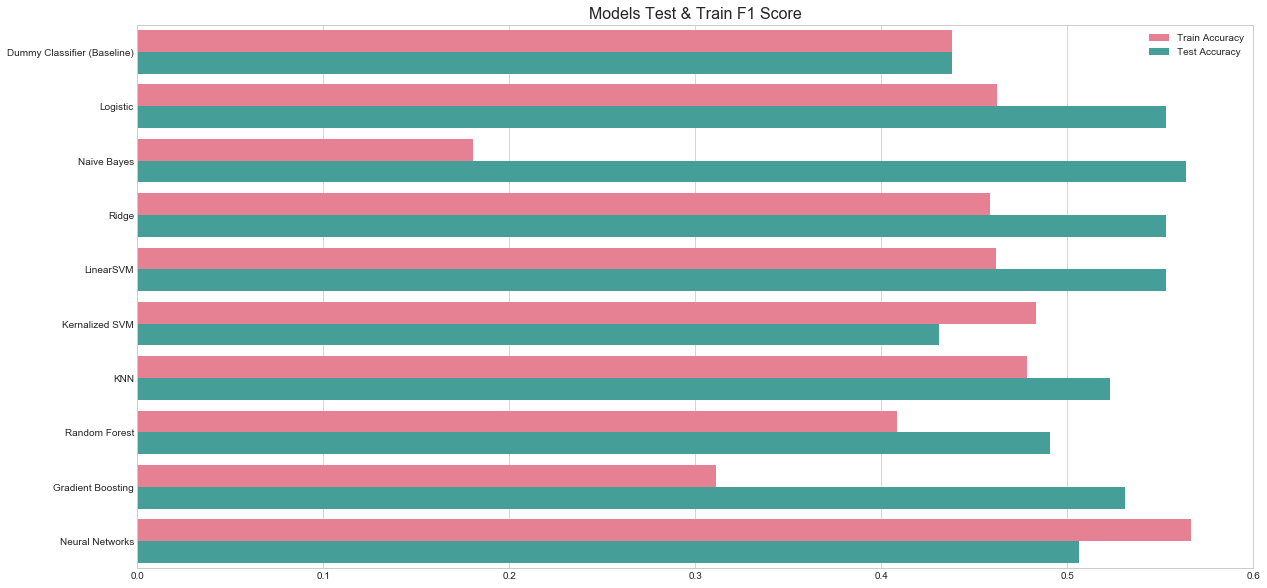

In [124]:
plt.figure(figsize = (20,10))
g = sns.barplot(x = 'F1',y='index', hue="Score Type",
                data = accuracy_scores,palette="husl")
g.set_title('Models Test & Train F1 Score',fontsize=16)
g.set_xlabel('')
g.set_ylabel('')
g.set_xlim([0,0.6])
legend = g.legend()
#plt.legend(labels = ['Price Decreased','Price Increased'])

Plot LSVC Precision-Recall Curve

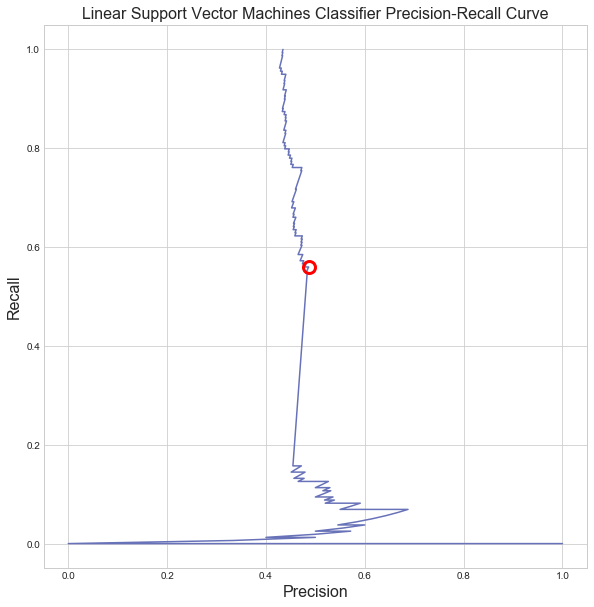

In [166]:
from sklearn.metrics import precision_recall_curve
y_scores = best_lsvc_model.decision_function(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
closest_zero = np.argmin(np.abs(thresholds))
closest_zero_p = precision[closest_zero]
closest_zero_r = recall[closest_zero]

plt.figure(figsize = (10,10))
plt.plot(precision, recall, label='Precision-Recall Curve',c='#6772b8')
plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)
plt.title('Linear Support Vector Machines Classifier Precision-Recall Curve',fontsize=16)
plt.axes().set_aspect('equal')
plt.show()

Plot LSVC auc roc cuve

In [126]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test,best_lsvc_model.predict(X_test))
roc_auc = auc(fpr, tpr)

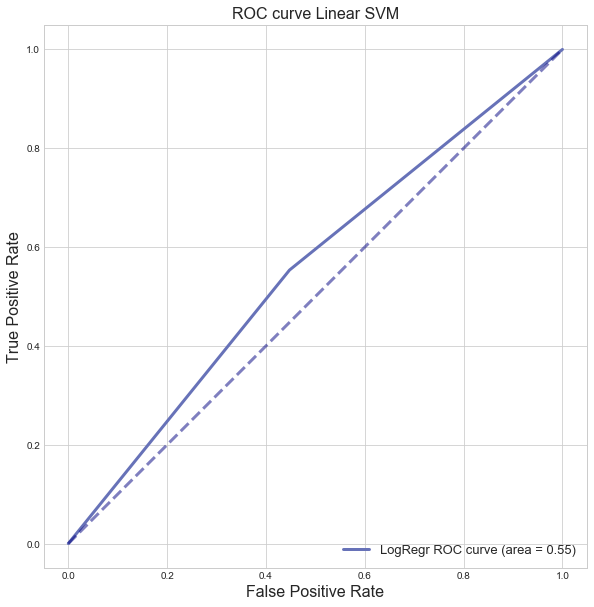

In [258]:
plt.figure(figsize = (15,10))
plt.plot(fpr, tpr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc),c = '#6772b8')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve Linear SVM', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--',alpha=0.5)
plt.axes().set_aspect('equal')
plt.show()

Classification report

In [399]:
print(metrics.classification_report(y_test,best_lsvc_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.62      0.55      0.59       210
           1       0.49      0.56      0.52       159

    accuracy                           0.56       369
   macro avg       0.55      0.56      0.55       369
weighted avg       0.56      0.56      0.56       369



Analyzing Linear SVM results

In [142]:
coef = pd.DataFrame(best_lsvc_model.coef_.T,index = ['Topic1','Topic2','Topic3','Topic4','Topic5'],
                    columns = ['coefficients']).reset_index().sort_values('coefficients')

Text(0.5,1,'Linear SVM feature coefficients')

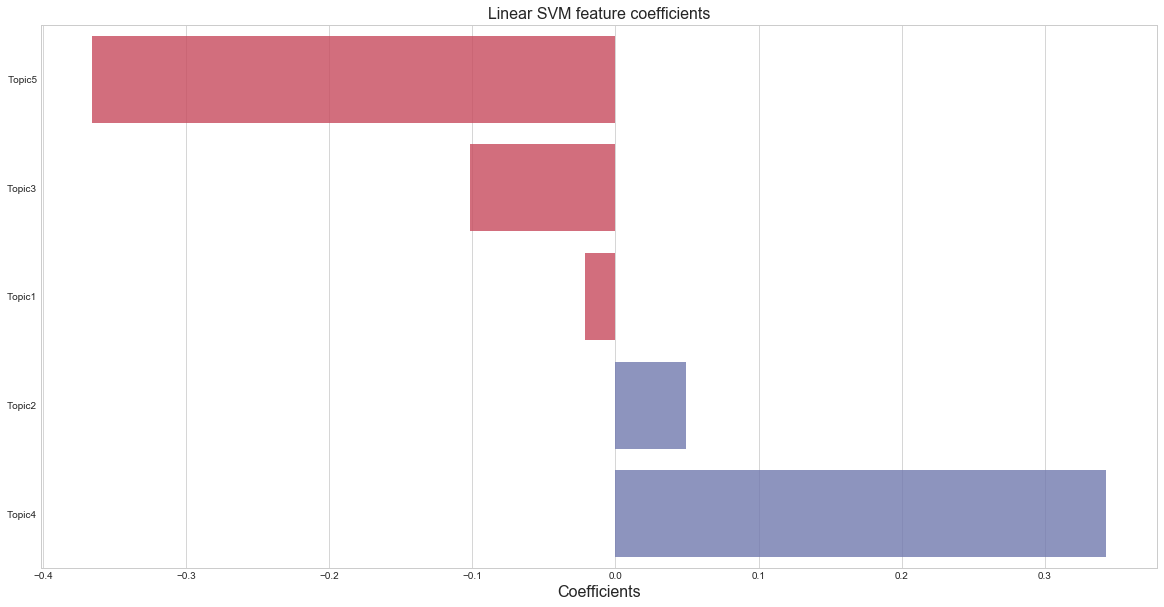

In [164]:
colors = ['#dc354e' if c <= 0 else '#6772b8' for c in coef['coefficients']]
plt.figure(figsize = (20,10))
g = sns.barplot(x = 'coefficients',y='index', data = coef,palette = colors,orient = "h",alpha=0.8)
g.set_xlabel('Coefficients',fontsize=16)
g.set_ylabel('')
g.set_title('Linear SVM feature coefficients',fontsize=16)